# PCA dan K-means Clustering

jika anda menggunakan google colab anda bisa mengetikan syntax dibawah ini untuk melakukan instalasi library yang dibutuhkan.

!pip install nltk <br>
!pip install pandas <br>
!pip install numpy <br>
!pip install scikit-learn <br>
!pip install sastrawi <br>


dan juga pastikan mengetikkan syntax dibawah ini untuk mendownload tambahan library dari nltk

import nltk<br>
nltk.download('popular')

# Crawling Data Pta Trunojoyo

sebelum melakukan proses crawling data, pastikan anda sudah menginstall library Scrapy dari python. Jika anda belum menginstall Scrapy anda dapat menginstall nya dengan cara ketikkan "pip install Scrapy" pada cmd

## Crawling pertama

pada proses crawling yang pertama ini, kita akan mengambil link yang ada pada halaman kumpulan judul pta. cara untuk melakukan crawling adalah:
1. buat file python (.py) misalkan "pta_trunojoyo.py".
2. copy paste code yang ada dibawah ini. (anda dapat memodifikasi kode ini sesuai dengan link pta yang anda inginkan).
3. jalankan file "pta_trunojoyo.py" dengan cara mengetikkan "scrapy runspider pta_trunojoyo.py -O link_pta.csv" , untuk yang bagian "link_pta.csv" ini merupakan output file yang anda crawling, karena disini saya menggunakan contoh "link_pta.csv" maka hasil outputnya dalam bentuk file csv.

In [1]:
import scrapy


class QuotesSpider(scrapy.Spider):
    name = "quotes"

    def start_requests(self):

        arrayData = ['https://pta.trunojoyo.ac.id/c_search/byprod/7']
        for i in range(2, 12):
            inArray = 'https://pta.trunojoyo.ac.id/c_search/byprod/7/' + str(i)
            arrayData.append(inArray)
        for url in arrayData:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
        for i in range(1,6):
            yield {
                'link': response.css('#content_journal > ul > li:nth-child(' + str(i) + ') > div:nth-child(3) > a::attr(href)').extract()
            }

## Crawling kedua

Untuk proses crawling yang kedua ini, saya mengambil link website pta hasil dari crawling pertama yang sudah di export dalam bentuk csv. untuk membaca file csv ini saya menggunakan library pandas. lalu setelah file dibaca, saya masukkan kedalam array. setelah itu masing masing link akan dilakukan proses crawling.
Pada proses cawling kedua ini kita akan menuju website pta nya langsung, untuk mendapatkan data judul, label dan isi dari masing-masing pta.
jalankan file ini dengan cara yang sama seperti yang pertama, akan tetapi sesuaikan nama filenya. cnothnya seperti "scrapy runspider pta_trunojoyo_data.py -O data_pta.csv"

In [2]:
import scrapy
import pandas as pd



class QuotesSpider(scrapy.Spider):
    name = "quotes"

    def start_requests(self):
        
        dataCSV = pd.read_csv('link_pta.csv')
        indexData = dataCSV.iloc[:, [0]].values
        arrayData = []
        for i in indexData:
            ambil = i[0]
            arrayData.append(ambil)
        for url in arrayData:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
        yield {
            'judul': response.css('#content_journal > ul > li > div:nth-child(2) > a::text').extract(),
            'penulis': response.css('#content_journal > ul > li > div:nth-child(2) > div:nth-child(2) > span::text').extract(),
            'dosen_1': response.css('#content_journal > ul > li > div:nth-child(2) > div:nth-child(3) > span::text').extract(),
            'dosen_2': response.css('#content_journal > ul > li > div:nth-child(2) > div:nth-child(4) > span::text').extract(),
            'abstrak_ID': response.css('#content_journal > ul > li > div:nth-child(4) > div:nth-child(2) > p::text').extract(),
            'abstrak_EN': response.css('#content_journal > ul > li > div:nth-child(4) > div:nth-child(4) > p::text').extract(),
            
        }

setelah proses crawling selesai, maka kita sudah dapat datanya dalam bentuk file csv. sebelum melakukan proses clustering kita olah dulu datanya. 

## prepocessing data

import library yang diperlukan untuk melakukan preprocessing data.

In [3]:
# import library
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

export file "data_pta.csv" dalam bentuk data frame pandas.

In [4]:
#import data frame
dataCSV = pd.read_csv('data_pta.csv')
dataCSV = dataCSV.drop(columns=['penulis', 'dosen_1','dosen_2', 'abstrak_EN'], axis=1)
dataCSV.head()

,judul,abstrak_ID
0,PENGARUH RELATIONSHIP MARKETING TERHADAP LOYAL...,Tujuan penelitian ini adalah untuk mengetahui ...
1,PENGARUH SELF EFFICACY TERHADAP PRESTASI AKADE...,Tujuan dari penelitian ini adalah untuk menget...
2,ANALISIS PERSEPSI BRAND ASSOCIATION MENURUT PE...,Tujuan penelitian ini adalah untuk mengetahui ...
3,Pengukuran Website Quality Pada Situs Sistem A...,Aplikasi nyata pemanfaatan teknologi informasi...
4,PENGARUH STRUKTUR MODAL DAN LIKUIDITAS TERHADA...,Pendekatan penelitian yang digunakan dalam pen...


## cek missing value

pandas menyediakan pengecekan missing value yaitu dengan method isna()

In [5]:
dataCSV.isna().sum()

judul         0
abstrak_ID    1
dtype: int64

hapus baris yang mengandung missing value, dengan fungsi pandas dropna()

In [6]:
dataCSV = dataCSV.dropna(axis=0, how='any')

cek lagi missing valuenya setelah di hapus kolom yang mengandung missing valuenya

In [7]:
dataCSV.isna().sum()

judul         0
abstrak_ID    0
dtype: int64

### Cleansing dan Stopword
disini kita melakukan cleansing data, yang artinya kita membersihkan data dari simbol, angka dan spasi. <br>
lalu untuk stopword ini untuk membuang kata yang tidak mempunyai makna seperti:
1. "dan"
2. "yang" 
3. "atau"
4. "adalah"

In [8]:
index_iloc = 0
len_df = len(dataCSV.index)
array_stopwords = []
for kata in range(len_df):
    # indexData itu ambil tiap bagian dari data frame dengan nama dataCSV
    indexData = dataCSV.iloc[index_iloc, [1]].values
    clean_words = [w for w in word_tokenize(indexData[0].lower())
                                    if w.isalpha()
                                    and w not in stopwords.words('indonesian')]
    
    array_stopwords.append(clean_words)
    index_iloc += 1

diatas ini adalah contoh isi dari salah satu berita yang sudah dilakukan cleansing dan stopword.

### Stemming

stemming ini merupakan proses untuk menghilangkan ibuhan pada tiap kata, sehingga tiap katanya merupakan kata dasar.
contohnya semisal kita mempunyai kata "memakan", maka setelah di stemming akan menjadi kata "makan"

In [9]:
# mendefinisikan function stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

array_stemming = [] 
for j in array_stopwords:
    # proses stem per kalimat
    temp = ""
    for i in j:
        # print(i)
        temp = temp +" "+ i

    hasil = stemmer.stem(temp)
    array_stemming.append(hasil)
# print('array ', array_stemming)

KeyboardInterrupt: 

dibawah ini adalah proses memasukkan data yang sudah dilakukan preprocessing ke dalam data frame yang mempunyai nama "dataSCV"

In [11]:
dataCSV = dataCSV.drop('abstrak_ID', axis=1)
dataCSV.head()


,judul
0,PENGARUH RELATIONSHIP MARKETING TERHADAP LOYAL...
1,PENGARUH SELF EFFICACY TERHADAP PRESTASI AKADE...
2,ANALISIS PERSEPSI BRAND ASSOCIATION MENURUT PE...
3,Pengukuran Website Quality Pada Situs Sistem A...
4,PENGARUH STRUKTUR MODAL DAN LIKUIDITAS TERHADA...


In [12]:
dataCSV['abstrak'] = np.array(array_stemming)
dataCSV.head()

,judul,abstrak
0,PENGARUH RELATIONSHIP MARKETING TERHADAP LOYAL...,tuju teliti pengaruh variabel relationship mar...
1,PENGARUH SELF EFFICACY TERHADAP PRESTASI AKADE...,tuju teliti pengaruh variabel self efficacy ma...
2,ANALISIS PERSEPSI BRAND ASSOCIATION MENURUT PE...,tuju teliti persepsi brand association langgan...
3,Pengukuran Website Quality Pada Situs Sistem A...,aplikasi nyata manfaat teknologi informasi kom...
4,PENGARUH STRUKTUR MODAL DAN LIKUIDITAS TERHADA...,dekat teliti teliti dekat kuantitatif populasi...


setelah dilakukan preprocessing data, kita lanjutkan untuk proses pembobotan dengan TF-IDF

## Term Frequency - Inverse Document Frequency (TF-IDF)

setelah melakukan pre-processing data, selanjutnya dilakukan proses TF-IDF <br>
TF-IDF adalah suatu metode algoritma untuk menghitung bobot setiap kata di setiap dokumen dalam korpus. Metode ini juga terkenal efisien, mudah dan memiliki hasil yang akurat. <br>
Term Frequency (TF) merupakan jumlah kemunculan kata pada setiap dokumen. dirumuskan dengan jumlah frekuensi kata terpilih / jumlah kata <br>
Inverse Document Matrix (IDF) dirumuskan dengan log((jumlah dokumen / jumlah frekuensi kata terpilih). <br>
untuk menghasilkan TF-IDF maka hasil dari TF dikalikan dengan IDF, seperti rumus dibawah ini:

$$
W_{i, j}=\frac{n_{i, j}}{\sum_{j=1}^{p} n_{j, i}} \log _{2} \frac{D}{d_{j}}
$$

Dengan:

$
{W_{i, j}}\quad\quad\>: \text { pembobotan tf-idf untuk term ke-j pada dokumen ke-i } \\
{n_{i, j}}\quad\quad\>\>: \text { jumlah kemunculan term ke-j pada dokumen ke-i }\\
{p} \quad\quad\quad\>\>: \text { banyaknya term yang terbentuk }\\
{\sum_{j=1}^{p} n_{j, i}}: \text { jumlah kemunculan seluruh term pada dokumen ke-i }\\
{d_{j}} \quad\quad\quad: \text { banyaknya dokumen yang mengandung term ke-j }\\
$



### import Library TF-IDF

import library yang dibutuhkan dalam melakukan pemrosesan TF-IDF dan juga ambil data dari data hasil preprocessing yang sudah dilakukan diatas.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
df = dataCSV

### Term Frequency

ubah data menjadi bentuk list, lalu lakukan proses tf dengan cara memanggil library CountVectorizer dari scikit-learn.

In [14]:
#mengubah fitur dalam bentuk list
list_isi_berita = []
for i in range(len(df.iloc[:, -1])):
    list_isi_berita.append(df.iloc[i, -1])

# proses term frequency
count_vectorizer = CountVectorizer(min_df=1)
tf = count_vectorizer.fit_transform(list_isi_berita)

#get fitur
fitur = count_vectorizer.get_feature_names_out()

# menampilkan data TF
show_tf = count_vectorizer.fit_transform(list_isi_berita).toarray()
df_tf =pd.DataFrame(data=show_tf,index=list(range(1, len(show_tf[:,1])+1, )),columns=[fitur])
df_tf = df_tf.T

df_tf.head(8)

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
abidin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abstrak,0,0,0,0,0,1,0,1,1,1,...,1,1,1,0,1,1,1,0,0,0
abtrak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accidental,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
acer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
action,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adaro,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adira,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

setelah melakukan proses TF, lakukan proses TF-IDF dan kemudian simpan hasilnya dalam bentuk data frame.

In [15]:
#tfidf dengan tfidf transformer
tfidf_transform = TfidfTransformer(use_idf=True,norm='l2',smooth_idf=True)
tfidf=tfidf_transform.fit_transform(count_vectorizer.fit_transform(list_isi_berita)).toarray()
df_tfidf =pd.DataFrame(data=tfidf,index=list(range(1, len(tfidf[:,1])+1, )),columns=[fitur])
df_tfidf.head(8)

,abidin,abstrak,abtrak,accidental,acer,action,adaro,adira,adjusted,administrasi,...,while,wilayah,wildan,windows,wispandono,with,xl,yakin,yamaha,yustina
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.241135,0.0,0.000000,...,0.0,0.160756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.186016,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.021070,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.046185,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## K-means Clustering

import library yang diperlukan

In [16]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## import Data

import data yang akan digunakan dalam proses clustering

In [17]:
#import data frame
df = pd.read_csv("tf-idf.csv")
df = df.drop("Unnamed: 0", axis=1)
df.head(5)

,abidin,abstrak,abtrak,accidental,acer,action,adaro,adira,adjusted,administrasi,...,while,wilayah,wildan,windows,wispandono,with,xl,yakin,yamaha,yustina
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.241135,0.0,0.000000,...,0.0,0.160756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.186016,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimentional reduction PCA

PCA adalah sebuah metode bagaimana mereduksi dimensi. dimana reduksi dimensi sendiri adalah pengurangan dimensi suatu dataset dengan pertimbangan bahwa informasi-informasi penting tetap dipertahankan. 

tahapan PCA yaitu:
1. mencari nilai rata-rata
2. mencari nilai zero mean
3. mencari nilai covarian matrix
4. mencari eigen value dan eigen vector

Nilai Means per dokumen

$$
\bar{x}=n\left(\sum_{i=1}^{n} \frac{1}{x_{i}}\right)^{-1}
$$

Nilai Varian dan Covarian

$$
\operatorname{var}(X)=\frac{\sum_{i=1}^{n}\left(X_{i}-\bar{X}\right)\left(X_{i}-\bar{X}\right)}{n-1}
$$

Keterangan:

$
X_{i} : \text {Populasi X ke i} \\
$

$
\bar{X} : \text {Mean dari populasi X}\\
$

$
n : \text {Jumlah populasi}\\
$

$$
\operatorname{cov}(X, Y)=\frac{\sum_{i=1}^{n}\left(X_{i}-\bar{X}\right)\left(Y_{i}-\bar{Y}\right)}{n-1}
$$

Keterangan:

$
X_{i} : \text {Populasi X ke i} \\
$

$
\bar{X} : \text {Mean dari populasi X}\\
$

$
Y_{i} : \text {Populasi X ke i} \\
$

$
\bar{Y} : \text {Mean dari populasi X}\\
$

$
n : \text {Jumlah populasi}\\
$

Nilai eigen value dan eigen vactor

$$
(\lambda I-A) \mathbf{v}=\mathbf{0}
$$

Keterangan:

$
\lambda : \text {eigen velue}\\
$

$
v : \text {eigen vactor}\\
$

In [18]:
# melihat n_component terbaik
# dengan cumulative explained variance
pca = PCA().fit(df)
cmv = pca.explained_variance_ratio_.cumsum()
print(cmv)
print(cmv.shape)

[0.05644606 0.10084699 0.13725456 0.17219095 0.20355431 0.23300805
 0.2617234  0.28948833 0.31549056 0.34024816 0.36442515 0.38818923
 0.41105617 0.43325542 0.45500296 0.47656163 0.49740548 0.51781542
 0.53783232 0.55774882 0.57735124 0.59605765 0.61465148 0.63288338
 0.65090543 0.66849227 0.6860094  0.70298021 0.71976072 0.73574046
 0.75161789 0.76678335 0.78166744 0.79636705 0.81094924 0.82521475
 0.83915799 0.85279328 0.86572152 0.87834031 0.89068576 0.90264755
 0.91439741 0.92582519 0.93630648 0.94643267 0.9564459  0.9659739
 0.97532565 0.9824733  0.9894325  0.99617039 1.         1.        ]
(54,)


code diatas untuk menunjukkan banyak componen terbaik yang dapat diambil. semakin mendekati nol maka data semakin kehilangan informasinya, dan jika semakin mendekati angka 1, informasi pada data tersebut akan semakin utuh.

setelah menentukan jumlah komponen terbaik yang dapat diambil, maka dilanjutkan dengan proses reduksi dimensinya. disini saya menggunakan n component sebanyak 50

In [19]:
# proses reduksi dimensi
pca = PCA(n_components=50)
X_df = pca.fit_transform(df)

## K-Means - Clustering

kali ini saya menggunakan metode elbow untuk menentukan jumlah cluster terbaik yang dapat diperoleh dari data pta trunojoyo.

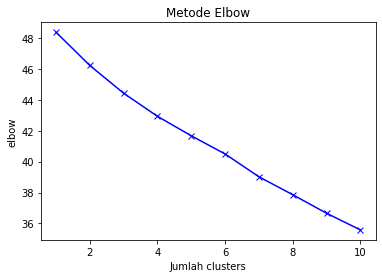

In [20]:
elbow = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=5)
    kmeans.fit(X_df)
    elbow.append(kmeans.inertia_)
plt.plot(range(1, 11), elbow, 'bx-')
plt.title('Metode Elbow')
plt.xlabel('Jumlah clusters')
plt.ylabel('elbow')
plt.show()

didapatkan cluster sama dengan 2, lanjut dengan proses training dengan metode k-means clustering

In [21]:
# kmeans clustering
kmeans = KMeans(n_clusters=2, random_state=5) # 2 clusters
kmeans.fit(X_df)
y_kmeans = kmeans.predict(X_df)
y_kmeans

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

berikut ini merupakan persebaran data dari pta trunojoyo, dengan dua klaster

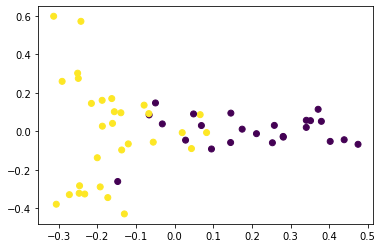

In [22]:
# ploting
plt.scatter(X_df[:, 0], X_df[:, 1], c=y_kmeans);